In [30]:
import torch

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
n_samples = 999

nfold = 10 # which means test_size = 0.1
torch.manual_seed(42)
rand_idx = torch.randperm(n_samples, device=device)
test_idx_each_split = torch.chunk(rand_idx, nfold, dim=0)
train_val_idx_each_split = [
    torch.cat(test_idx_each_split[:i] + test_idx_each_split[i+1:])
    for i in range(nfold)
]

In [31]:
def random_subset(tensor, num_subset, seed=42):
    torch.manual_seed(seed)
    num_rows = tensor.size(0)
    rand_perm = torch.randperm(num_rows, device=device)
    return tensor[rand_perm[:num_subset]], tensor[rand_perm[num_subset:]]

In [32]:
train_idx_each_split = []
val_idx_each_split = []

for i in range(nfold):
    val_idx, train_idx = random_subset(train_val_idx_each_split[i], test_idx_each_split[i].size(0))
    train_idx_each_split.append(train_idx)
    val_idx_each_split.append(val_idx)


In [33]:
train_idx_each_split[0].shape, val_idx_each_split[0].shape, test_idx_each_split[0].shape

(torch.Size([799]), torch.Size([100]), torch.Size([100]))

In [34]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
class FlipTensor(object):
    def __call__(self, x):
        return torch.flip(x, dims=[0])
    
transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # FlipTensor()
])
image_folder = ImageFolder(root='../archive/Data/images_original', transform=transform)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

data = torch.stack(
    [torch.from_numpy(np.array(image_folder[i][0])) for i in range(len(image_folder))],
    dim=0
).to(device)
labels = torch.tensor(
    [image_folder[i][1] for i in range(len(image_folder))], device=device
)

In [36]:
data.shape

torch.Size([999, 3, 256, 256])

In [37]:
import sys

sys.path.append('..')

In [38]:
import logging
import warnings

from torch.utils.data import TensorDataset
import torchvision.models as models
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import accuracy_score, f1_score

from audio_toolbox.trainer import ModelTrainer

logging.basicConfig(level=logging.INFO)

test_losses, f1_scores = [], []
demo_loss_curve = None
best_state_dict_folds = None
max_test_acc = 0.
for fold_idx in range(nfold):
    train_data, train_label = data[train_idx_each_split[fold_idx]], labels[train_idx_each_split[fold_idx]]
    val_data, val_label = data[val_idx_each_split[fold_idx]], labels[val_idx_each_split[fold_idx]]
    test_data, test_label = data[test_idx_each_split[fold_idx]], labels[test_idx_each_split[fold_idx]]
    
    datasets = {
        'train': TensorDataset(train_data, train_label),
        'val': TensorDataset(val_data, val_label),
        'test': TensorDataset(test_data, test_label)
    }
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        vgg16 = models.vgg16(pretrained=True).to(device)
        
        # Remove last 7 convolutional layers
        vgg16.features = torch.nn.Sequential(*list(vgg16.features.children())[:-7])
        for param in vgg16.features.parameters():
            param.requires_grad = True
        
    vgg16.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25088, 4096, device=device),
        nn.Dropout(0.8, inplace=True),
        nn.ReLU(),
        nn.Linear(4096, 10, device=device)
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    learning_rate = 1e-4  # Adjust the learning rate as needed
    optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    trainer = ModelTrainer(datasets, vgg16, loss_fn, optimizer, scheduler)
    trainer_config = {
        'save': False,
        'num_epochs': 50,
        'batch_size': 32,
        'batch_tqdm': False,
        'log_per': 10,
        'metric': 'acc',
        'early_stopping': True,
        'patience': 10,
    }
    best_state_dict = trainer.train(**trainer_config)
    trainer.load_model(best_state_dict)
    pred_label = trainer.predict(test_data)
    
    test_losses.append(accuracy_score(test_label.cpu().numpy(), pred_label.cpu().numpy()))
    if test_losses[-1] > max_test_acc:
        max_test_acc = test_losses[-1]
        demo_loss_curve = trainer.get_metric_record()
        best_state_dict_folds = best_state_dict
    f1_scores.append(f1_score(test_label.cpu().numpy(), pred_label.cpu().numpy(), average='macro'))
    logging.info(f'Fold {fold_idx} test accuracy: {test_losses[-1]:.4f}\n')

INFO:root:Epoch 0001, Learning rate: 0.000100, Training metric: 0.55194, Val metric: 0.45312, Test metric: 0.57031, Epoch time: 5.35091
INFO:root:Epoch 0011, Learning rate: 0.000050, Training metric: 0.99875, Val metric: 0.78906, Test metric: 0.89844, Epoch time: 5.39524
INFO:root:Early stopping triggered
INFO:root:Best model at epoch 0008 with validation metric 0.83594
INFO:root:Fold 0 test accuracy: 0.8500

INFO:root:Epoch 0001, Learning rate: 0.000100, Training metric: 0.61843, Val metric: 0.52344, Test metric: 0.62500, Epoch time: 5.38479
INFO:root:Epoch 0011, Learning rate: 0.000050, Training metric: 1.00000, Val metric: 0.82812, Test metric: 0.68750, Epoch time: 5.42081
INFO:root:Epoch 0021, Learning rate: 0.000025, Training metric: 1.00000, Val metric: 0.77344, Test metric: 0.70312, Epoch time: 5.42281
INFO:root:Early stopping triggered
INFO:root:Best model at epoch 0014 with validation metric 0.84375
INFO:root:Fold 1 test accuracy: 0.7600

INFO:root:Epoch 0001, Learning rate: 0

In [54]:
print(f"10-fold average f1 score: {np.mean(f1_scores):.4f}")
print(f"10-fold average accuracy: {np.mean(test_losses) * 100:.2f}%")

10-fold average f1 score: 0.7766
10-fold average accuracy: 78.98%


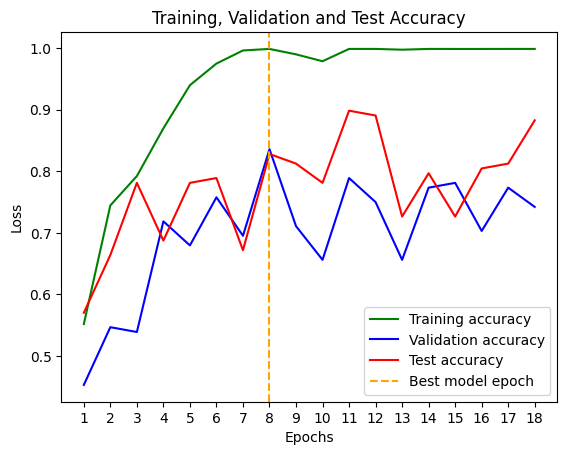

In [55]:
import matplotlib.pyplot as plt

train_acc = demo_loss_curve['train']
val_acc = demo_loss_curve['val']
test_acc = demo_loss_curve['test']

epochs = range(1, len(train_acc) + 1, 1)
selected_epoch = np.argmax(val_acc) + 1

plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, test_acc, 'r', label='Test accuracy')
plt.axvline(x=selected_epoch, color='orange', linestyle='--', label='Best model epoch')

plt.title('Training, Validation and Test Accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()
